# Time-Domain simulations


## Observables

You can compute multiple observables in one run

In [1]:
from granad import MaterialCatalog, Hexagon, Pulse
flake = MaterialCatalog.get("graphene").cut_flake( Hexagon(10) )

pulse = Pulse(
    amplitudes=[1e-5, 0, 0], frequency=2.3, peak=5, fwhm=2
)

operators = [flake.dipole_operator, flake.velocity_operator]

result = flake.td_run(
    relaxation_rate = 1/10,
    illumination = pulse,
    expectation_values = operators,
    end_time = 40,
     )

finished timestep 0
RHS compiled


The result object stores this info. Operators are concatenated in the order you passed them in.

In [2]:
print(len(result.output))
print(result.output[0].shape)

1
(4000, 6)


The induced dipole moment at timestep 10 is given by

In [3]:
print(result.output[0][10,:3])

[9.05330966e-13+0.j 1.58297657e-13+0.j 0.00000000e+00+0.j]


Induced current at timestep 10

In [4]:
print(result.output[0][10,3:])

[ 1.33103192e-11+6.17228924e-15j -1.09182314e-14-9.83546108e-15j
  0.00000000e+00+0.00000000e+00j]


We can access the Fourier transform as

In [5]:
omega_min, omega_max = 0, 5
omegas, pulse_omega = result.ft_illumination( omega_min = omega_min, omega_max = omega_max )
output_omega = result.ft_output( omega_min = omega_min, omega_max = omega_max )[0]
#

# So we can quickly check the continuity equation

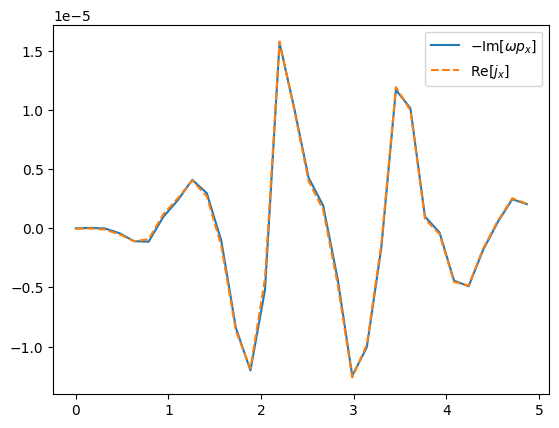

In [6]:
import matplotlib.pyplot as plt
p = -(omegas * output_omega[:,0]).imag
j = output_omega[:,3].real
plt.plot(omegas, p, label = r'$- \text{Im}[\omega p_x]$')
plt.plot(omegas, j, '--', label = r'$\text{Re}[j_x]$')
plt.legend()
plt.show()

The field is also accessible

In [7]:
print(result.td_illumination.shape)

(4000, 3)


*WARNING: The following behavior might change and the density_matrix argument may be removed*

## Density matrices

If we want to only get density matrices, we can simply omit the observables dictionary. The result object then contains a single generic dictionary item.

In [8]:
result = flake.td_run(
    relaxation_rate = 1/10,
    illumination = pulse,
    end_time = 40,
    density_matrix = ["full"],
     )
density_matrix = result.output[0]
print(density_matrix.shape)

finished timestep 0
RHS compiled


(4000, 87, 87)


We can convert them to energy basis

In [9]:
density_matrix_e = flake.transform_to_energy_basis( density_matrix )
print(density_matrix_e.shape)

(4000, 87, 87)


## Occupations

We can extract only site occupations

In [10]:
result = flake.td_run(
    relaxation_rate = 1/10,
    illumination = pulse,
    density_matrix = ["occ_x"],
    end_time = 40,
     )
occ_x = result.output[0]
print(occ_x.shape)

finished timestep 0
RHS compiled


(4000, 87)


We can extract only energy occupations

*DANGER*: this introduces additional cubic complexity 

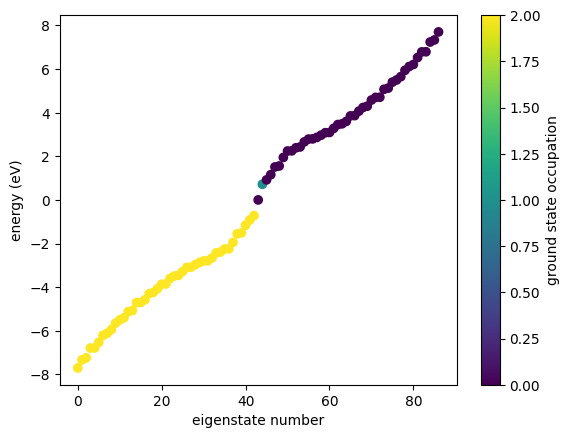

finished timestep 0
RHS compiled


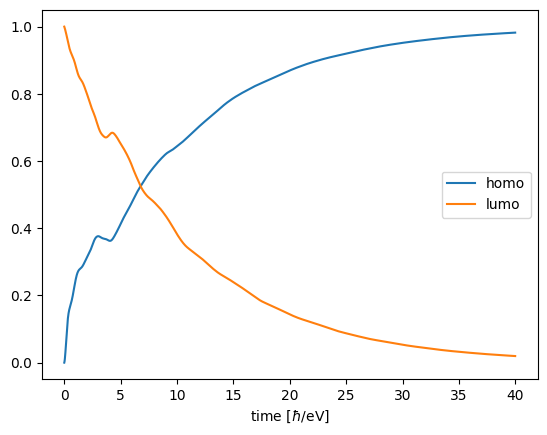

In [11]:
flake.set_excitation( flake.homo, flake.homo + 1, 1)
flake.show_energies()
result = flake.td_run(
    relaxation_rate = 1/10,
    density_matrix = ["occ_e"],
    end_time = 40,
     )
flake.show_res(result, plot_only = [flake.homo, flake.homo+1], plot_labels = ["homo", "lumo"], show_illumination = False )

## Combinations

We can also extract multiple things at the same time

In [12]:
result = flake.td_run(
    relaxation_rate = 1/10,
    density_matrix = ["full", "occ_x"],
    expectation_values = [flake.dipole_operator],
    end_time = 40,
    illumination = pulse,
)

finished timestep 0
RHS compiled


The output will now contain three arrays: induced dipole moments, site occupations and full density matrices

In [13]:
print(len(result.output))
print(result.output[0].shape) # by default, operators come first
print(result.output[1].shape) # we specified ["full", "occ_x"] => full density matrices
print(result.output[2].shape) # we specified ["full", "occ_x"] => site occupations

3
(4000, 3)
(4000, 87, 87)
(4000, 87)


## Custom computations

TBD

## Automatic Convergence Check

TBD

## Parameters

TBD